#### 環境  
```
Python 3.5.1 |Anaconda custom (x86_64)| (default, Jun 15 2016, 16:14:02) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)] on darwin

IPython 5.0.0 
```




In [1]:
import numpy as np
import pandas as pd
import numpy.random as rd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

sns.set(style="darkgrid", palette="muted", color_codes=True)

In [2]:
# Jupyter Notebook上でcythonファイルのコンパイルができるようにする
%load_ext Cython

In [3]:
%%cython -n test_cython_code
def fib(int n):
    cdef int i
    cdef double a=0.0, b=1.0

    for i in range(n):
        a, b = a+b, a
    return a

def primes(int kmax):
    cdef int n, k, i
    cdef int p[1000]
    result = []

    # 最大個数は1000個
    if kmax > 1000:
        kmax = 1000

    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i += 1

        if i == k:
            p[k] = n
            k += 1
            result.append(n)
        n += 1
    return result

In [4]:
# 試してみる
print(fib(90))
print(primes(20))

2.880067194370816e+18
[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]


In [5]:
# 性能比較用　Python関数
def pyfib(n):
    a, b = 0.0, 1.0
    for i in range(n):
        a, b = a+b, a
    return a

def pyprimes(kmax):
    p = np.zeros(1000)
    result = []

    # 最大個数は1000個
    if kmax > 1000:
        kmax = 1000

    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i += 1

        if i == k:
            p[k] = n
            k += 1
            result.append(n)
        n += 1
    return result

In [6]:
%timeit fib(1000)
%timeit pyfib(1000)

1000000 loops, best of 3: 785 ns per loop
10000 loops, best of 3: 41.1 µs per loop


In [7]:
%timeit primes(1000)
%timeit pyprimes(1000)

1000 loops, best of 3: 1.66 ms per loop
1 loop, best of 3: 212 ms per loop


### pandasのapplyに適用

In [8]:
df = pd.DataFrame(np.arange(1, 10**4), columns=['num'] )
df.head()

,num
0,1
1,2
2,3
3,4
4,5


In [9]:
%timeit df['fib'] = df.num.apply(fib)
%timeit df['pyfib'] = df.num.apply(pyfib)


10 loops, best of 3: 41.5 ms per loop
1 loop, best of 3: 2.16 s per loop


In [10]:
print(df.head())

   num  fib  pyfib
0    1  1.0    1.0
1    2  1.0    1.0
2    3  2.0    2.0
3    4  3.0    3.0
4    5  5.0    5.0


### ndarrayを扱う

In [11]:
# データを作る
rd.seed(71)
n_data = 10**5
X = pd.DataFrame(rd.normal(size=3*n_data).reshape((n_data,3)), columns=["a", "b", "c"])
print(X.shape)
print(X.head())

(100000, 3)
          a         b         c
0 -0.430603 -1.193928 -0.444299
1  0.489412 -0.451557  0.585696
2  1.177320 -0.965009  0.218278
3 -0.866144 -0.323006  1.412919
4 -0.712651 -1.362191 -1.705966


In [12]:
%%cython -n sample_calc 
import numpy as np
cimport numpy as np

cpdef np.ndarray[double] sample_calc(np.ndarray col_a, np.ndarray col_b, np.ndarray col_c):
    # 各列の型チェック
    assert (col_a.dtype == np.float and col_b.dtype == np.float and col_c.dtype == np.float)
    
    # 各列のサイズが同じであることをチェック
    cdef Py_ssize_t n = len(col_c)
    assert (len(col_a) == len(col_b) == n)
    cdef np.ndarray[double] res = np.empty(n)
    
    # (a-b)/c という計算をする
    for i in range(n):
        res[i] = (col_a[i] - col_b[i])/col_c[i]
    return res

In [13]:
sample_calc(X.a.values, X.b.values, X.c.values)

array([-1.71804336,  1.60658332,  9.81468496, ..., -0.44683095,
        0.46970409, -0.28352272])

In [14]:
# 比較用
def pysample_calc(col_a, col_b, col_c):
    # 各列の型チェック
    assert (col_a.dtype == np.float and col_b.dtype == np.float and col_c.dtype == np.float)
    
    # 各列のサイズが同じであることをチェック
    n = len(col_c)
    assert (len(col_a) == len(col_b) == n)
    res = np.empty(n)
    
    # (a-b)/c という計算をする
    for i in range(n):
        res[i] = (col_a[i] - col_b[i])/col_c[i]
    return res

In [15]:
%timeit sample_calc(X.a.values, X.b.values, X.c.values)
%timeit pysample_calc(X.a.values, X.b.values, X.c.values)

100 loops, best of 3: 17.9 ms per loop
10 loops, best of 3: 37.3 ms per loop


### モンテカルロ法で円周率を計算

In [16]:
# データ生成
rd.seed(71)
n_data = 10**7
X2 = rd.random(size=(n_data,2)).astype(np.float)
X2.dtype

dtype('float64')

In [17]:
%%cython -n calc_pi
import numpy as np
cimport numpy as np

cpdef np.ndarray[long]  calc_pi(np.ndarray[double, ndim=2] data):
    cdef Py_ssize_t n = len(data)
    cdef np.ndarray[long] res = np.empty(n, dtype=np.int)
    
    for i in range(n):
        res[i] = 1 if (data[i,0]**2 + data[i,1]**2) < 1 else 0
    return res 

In [18]:
# 比較用Python関数
def pycalc_pi(data):
    n = len(data)
    res = np.empty(n, dtype=np.int)
    
    res = [1 if (data[i,0]**2 + data[i,1]**2) < 1 else 0 for i in range(n)]
    return res

In [19]:
%time res = calc_pi(X2)
%time respy = pycalc_pi(X2)

CPU times: user 33.6 ms, sys: 21 ms, total: 54.6 ms
Wall time: 54.4 ms
CPU times: user 7.82 s, sys: 50.1 ms, total: 7.87 s
Wall time: 7.87 s


In [20]:
# 結果が同一か確認
np.all(res == respy)

True

In [21]:
# 円周率の計算
np.sum(res)/n_data*4

3.1413555999999998

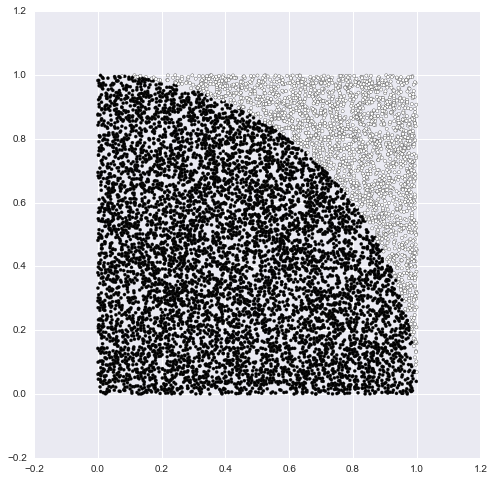

In [22]:
# 描画する
n_plot = 10**4  # 描画する点の数
plt.figure(figsize=(8,8))
plt.scatter(X2[:n_plot,0], X2[:n_plot,1], c=res[:n_plot], s=10)

### 参考

Cython チュートリアル基礎編  
http://omake.accense.com/static/doc-ja/cython/src/userguide/tutorial.html

オライリー Cython  
https://www.oreilly.co.jp/books/9784873117270/

pandas 0.18.1 documentation  Enhancing Performance  
http://pandas.pydata.org/pandas-docs/stable/enhancingperf.html